In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings 
warnings.simplefilter('ignore')

# Predicting Airline Cancellations

# Airlines Team

#### Michael Dang, Harrison Teplitz, Daniel Liao, Quinn Hayes, Shruti Motiwale

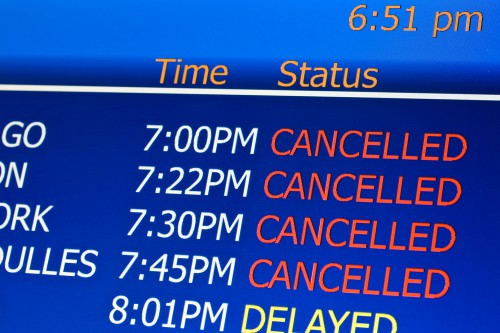

In [ ]:
img = '0a1-130.jpg'
#https://www.eturbonews.com/544211/us-airports-ranked-by-flight-cancellation-rates/
img = 'image2.jpg'
#https://www.cheapair.com/blog/cheapair-coms-holiday-guide-to-coping-with-a-flight-delay-or-cancellation/
Image(filename=img)

## Importing data

In [ ]:
df_full_data = pd.read_csv("Processed_data/2018_to_2019_bts.csv", nrows=5)
df_full_data

,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,Flight_Number_Marketing_Airline,Origin,OriginCityName,OriginState,Dest,...,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DivAirportLandings
0,27,6,2018-01-27,UA,UA,369,FLL,"Fort Lauderdale, FL",FL,IAH,...,148.0,1.0,966.0,4,NaN,NaN,NaN,NaN,NaN,0
1,27,6,2018-01-27,UA,UA,368,SEA,"Seattle, WA",WA,SFO,...,98.0,1.0,679.0,3,NaN,NaN,NaN,NaN,NaN,0
2,27,6,2018-01-27,UA,UA,367,DCA,"Washington, DC",VA,IAH,...,190.0,1.0,1208.0,5,NaN,NaN,NaN,NaN,NaN,0
3,27,6,2018-01-27,UA,UA,366,LAX,"Los Angeles, CA",CA,ORD,...,212.0,1.0,1744.0,7,NaN,NaN,NaN,NaN,NaN,0
4,27,6,2018-01-27,UA,UA,365,JAX,"Jacksonville, FL",FL,EWR,...,112.0,1.0,820.0,4,NaN,NaN,NaN,NaN,NaN,0


Compiling a list of the data columns we want to import

In [ ]:
#Columns we want to import into memory
columns = ['OriginState','DestState','Diverted','Marketing_Airline_Network',
           'FlightDate','Cancelled','Operated_or_Branded_Code_Share_Partners',
           'CancellationCode','Origin','Dest','DepTimeBlk','ArrTimeBlk',
           'CRSDepTime','CRSArrTime','CRSElapsedTime','Distance']

In [ ]:
%%time
#Import these columns into memory
df = pd.read_csv("Processed_data/2018_to_2019_bts.csv", usecols = columns)

CPU times: user 46.3 s, sys: 7.41 s, total: 53.7 s
Wall time: 56.2 s


In [ ]:
df.head()

,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,Origin,OriginState,Dest,DestState,CRSDepTime,DepTimeBlk,CRSArrTime,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,Distance
0,2018-01-27,UA,UA,FLL,FL,IAH,TX,615,0600-0659,808,0800-0859,0.0,NaN,0.0,173.0,966.0
1,2018-01-27,UA,UA,SEA,WA,SFO,CA,618,0600-0659,831,0800-0859,0.0,NaN,0.0,133.0,679.0
2,2018-01-27,UA,UA,DCA,VA,IAH,TX,830,0800-0859,1107,1100-1159,0.0,NaN,0.0,217.0,1208.0
3,2018-01-27,UA,UA,LAX,CA,ORD,IL,650,0600-0659,1250,1200-1259,0.0,NaN,0.0,240.0,1744.0
4,2018-01-27,UA,UA,JAX,FL,EWR,NJ,1824,1800-1859,2045,2000-2059,0.0,NaN,0.0,141.0,820.0


# Data exploration in Tableau

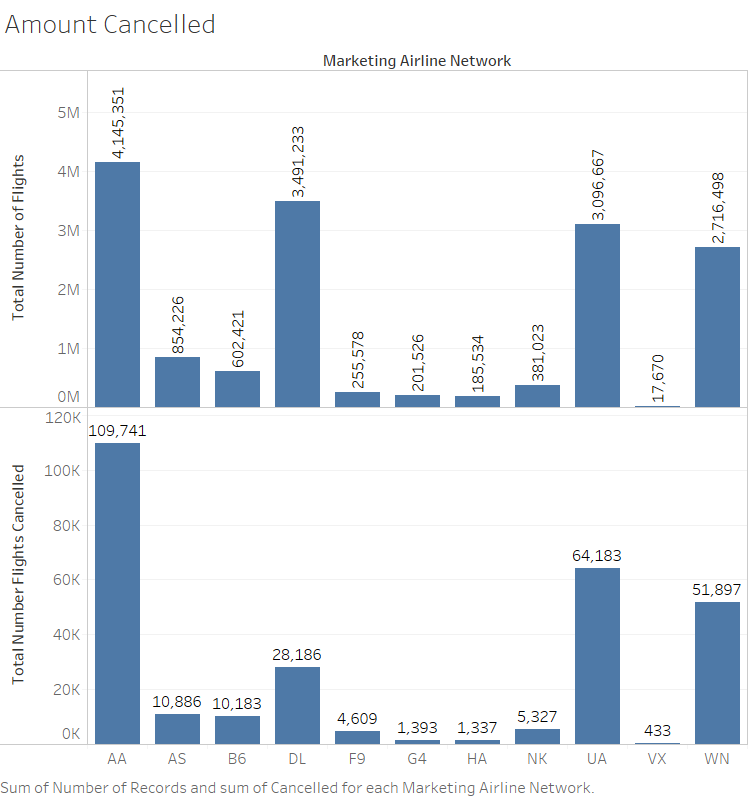

In [ ]:
img = 'Tableau/Images/Amount_Cancelled.png'
Image(filename=img)

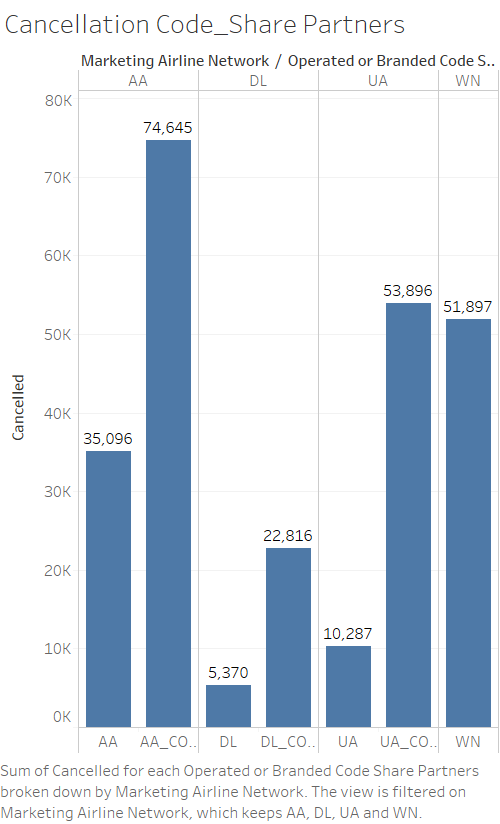

In [ ]:
img = 'Tableau/Images/Cancellation_Code_Share Partners.png'
Image(filename=img)


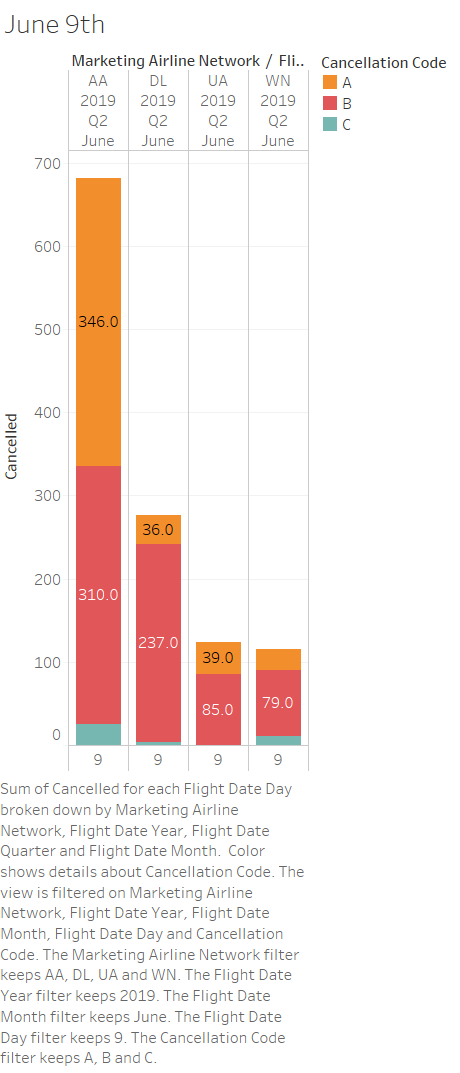

In [ ]:
img = 'Tableau/Images/June_9th.png'
Image(filename=img)

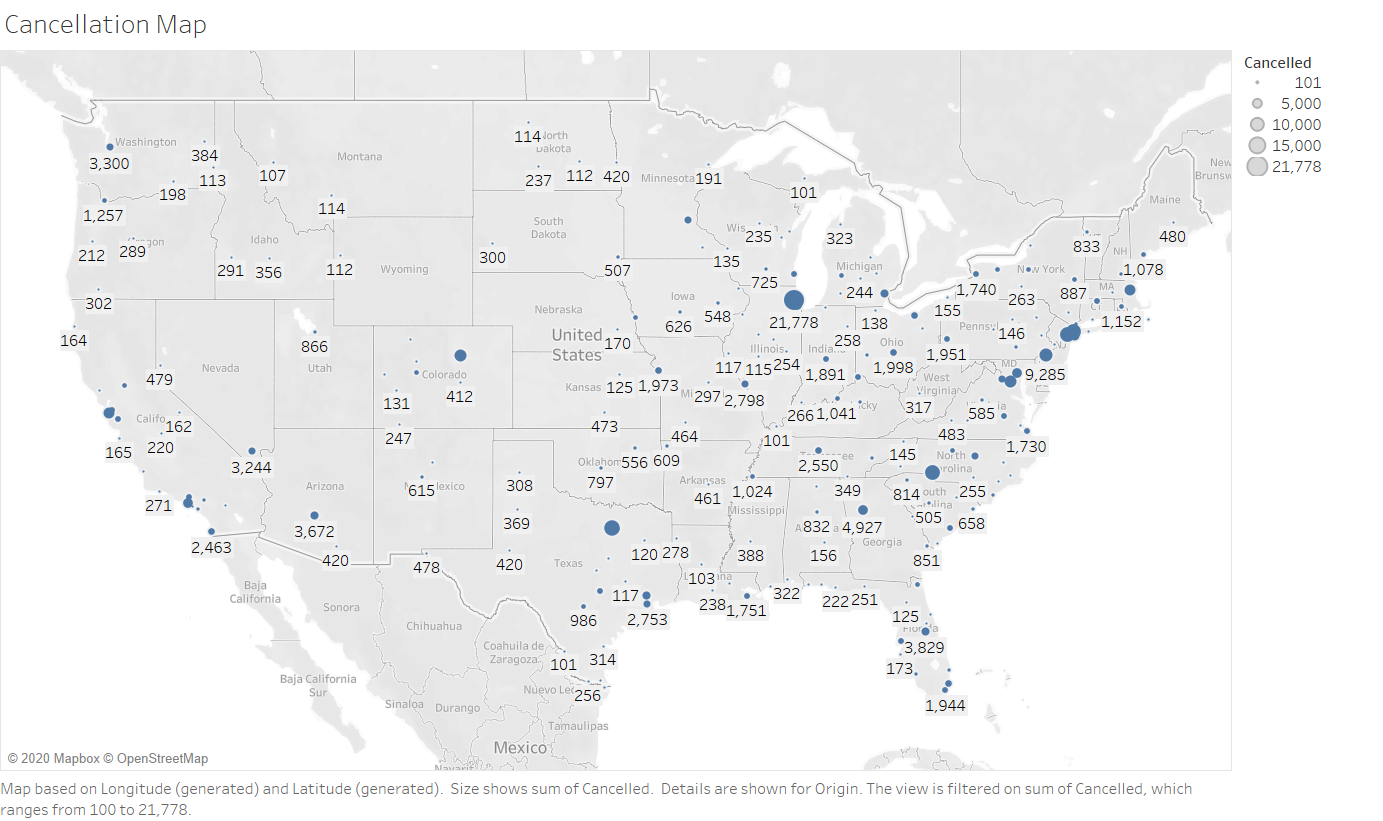

In [ ]:
img = 'Tableau/Images/Cancellation_Map.png'
Image(filename=img)
#Highlights Regions of the United States

# Preparing Data

Select days that had storms, and then understand codeA cancellations for those days

In [ ]:
#Import data from a set of days that have storms dfStorm
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
dates_train = ['2018-01-04','2018-03-21','2018-09-14','2019-01-29','2019-06-09','2019-08-19','2018-03-02','2018-06-16','2019-02-22','2019-04-14','2019-11-11','2018-02-05','2018-04-22','2018-10-15','2019-02-28','2019-07-16','2019-09-22','2018-05-20']
## last few dates in dates_train are random days... i wanted to even out the dataset so not only training on days w/ high cancellations
#Test dates are just random dates
dates_score = ['2018-03-05','2018-05-22','2018-10-15','2019-03-28','2019-08-16','2019-10-22','2018-06-20']
dates = dates_train + dates_score
#Put data for the dates we are testing or training into dfStorm
dfStorm = df[df['FlightDate'].isin(dates)]  

And we will look at AA specifically

In [ ]:
#Drop any data that isn't for AA
aa = dfStorm['Marketing_Airline_Network'] == 'AA'
dfStorm = dfStorm[aa]

And, we are only interested in CancellationCode A where the cause of cancellation is the Carrier

In [ ]:
#If the flight isn't cancelled, set the cancellation code to Z
dfStorm['CancellationCode'] = dfStorm['CancellationCode'].fillna('Z')

In [ ]:
## Reduce dataset to only cancelled code A and not cancelled flights
#fault = dfStorm['CancellationCode'] == 'A'
ran = dfStorm['CancellationCode'] == 'Z'
dfFault = dfStorm[dfStorm['CancellationCode'].isin(['A'])]
dfRan = dfStorm[ran]
dfStorm = dfFault.append(dfRan)

Sample from the uncancelled flights such that the number of uncancelled flights equals the number of cancelled flights or 'balance' the target

In [ ]:
# Target balancing
bal = dfStorm.groupby('Cancelled')
minority_size = bal.size().min()
ratio = 1
dfStorm = pd.DataFrame(bal.apply(lambda x: x.sample(ratio * minority_size, random_state=33))).droplevel(level=0, axis=0)
#dfStorm = pd.DataFrame(bal.apply(lambda x: x.sample(ratio * minority_size).reset_index(drop=True)))
#dfStorm = dfStorm.droplevel(level=0, axis=0)

In [ ]:
print(dfStorm.Cancelled.value_counts())

1.0    1609
0.0    1609
Name: Cancelled, dtype: int64


# Feature Engineering

### Create features containing information about hubs

In [ ]:
#Manually make a hubs dictionary for all marketing airlines
Hubs = {'AA':['CLT','ORF','ORD','DFW','LAX','MIA','JFK', 'LGA','PHL','PHX','DCA'],
      'WN': ['ATL', 'BWI', 'MDW', 'DAL', 'DEN', 'HOU','LAS', 'LAX', 'OAK', 'MCO','PHX'],
       'UA': ['ORD', 'DEN', 'GUM', 'IAH', 'LAX', 'EWR', 'SFO', 'IAD'],
       'DL': ['ATL', 'BOS', 'DTW', 'LAX', 'MSP', 'JFK', 'LGA', 'SLC', 'SEA'],
        'AS' : ['ANC', 'LAX', 'PDX', 'SFO', 'SEA'],
        'B6' : ['BOS', 'FLL', 'LGB', 'JFK', 'MCO', 'SJU'],
        'F9' : ['ATL', 'ORD', 'CLE', 'CVG', 'LAS', 'MIA', 'MCO', 'PHL', 'RDU', 'TTN'],
        'G4' : ['ABE', 'AVL', 'BLI', 'CVG', 'USA', 'VPS', 'FLL', 'GRR', 'IND', 'TYS', 'LAS', 'LAX', 'BNA', 'OAK', 'SFB', 'AZA', 'PIT', 'PGD', 'SAV', 'PIE'],
        'HA' : ['HNL', 'OGG'],
        'NK' : ['ACY', 'ORD', 'DFW', 'DTW', 'FLL', 'LAS', 'MCO'],
        'VX' : ['LAX', 'SFO'],
         }

In [ ]:
#Map the hub to the airpot based off the marketing airline
dfStorm['AirlineHubs'] = dfStorm['Marketing_Airline_Network'].map(Hubs)

In [ ]:
#One Hot variable creation for hubs
dfStorm['IsDestHub'] = dfStorm.apply(lambda x: (x.Dest in x.AirlineHubs)*1, axis=1)

dfStorm['IsOrigHub'] = dfStorm.apply(lambda x: (x.Origin in x.AirlineHubs)*1, axis=1)

dfStorm['Hub2Hub'] = dfStorm['IsOrigHub']*dfStorm['IsDestHub']

In [ ]:
#Create ordinal feature with 0,1,2 being the number of hubs involved in the flight
dfStorm['Hubs'] = dfStorm['IsDestHub'] + dfStorm['IsOrigHub']

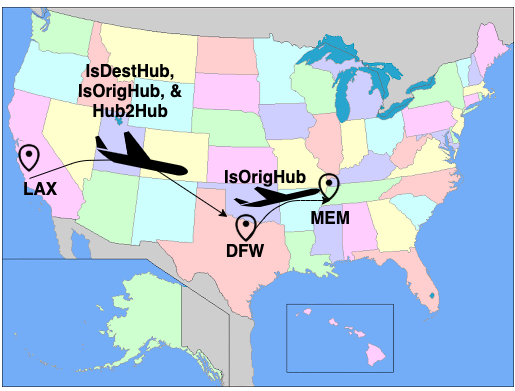

In [ ]:
img = 'Feature images/Hub feature new.png'
Image(filename=img)

### Feature for airport and airline density

In [ ]:
dfStorm['AirportTakeOffDensity'] = dfStorm.groupby(['Origin', 'DepTimeBlk', 'FlightDate'])['Origin'].transform('size')

#Count all occurances of *scheduled landing to an airport within an hour 
dfStorm['AirportLandingDensity'] = dfStorm.groupby(['Dest', 'ArrTimeBlk', 'FlightDate'])['Origin'].transform('size')

#Count all occurances of *scheduled departures from a marketing airline within an hour
dfStorm['AirlineDensity'] = dfStorm.groupby(['Marketing_Airline_Network', 'DepTimeBlk', 'FlightDate'])['Origin'].transform('size')

### Season feature

In [ ]:
#Manually build dictionary for season by month number
Mon2Sea = {1: 'W', 2: 'W', 3: 'Sp', 4:'Sp', 5: 'Sp', 6: 'Su', 7: 'Su', 8: 'Su', 9:'F', 10: 'F', 11: 'F', 12: 'W'}

#Map the season to the month number registered with the flight
dfStorm['Month'] = pd.DatetimeIndex(dfStorm['FlightDate']).month
dfStorm['Season'] = dfStorm['Month'].map(Mon2Sea)

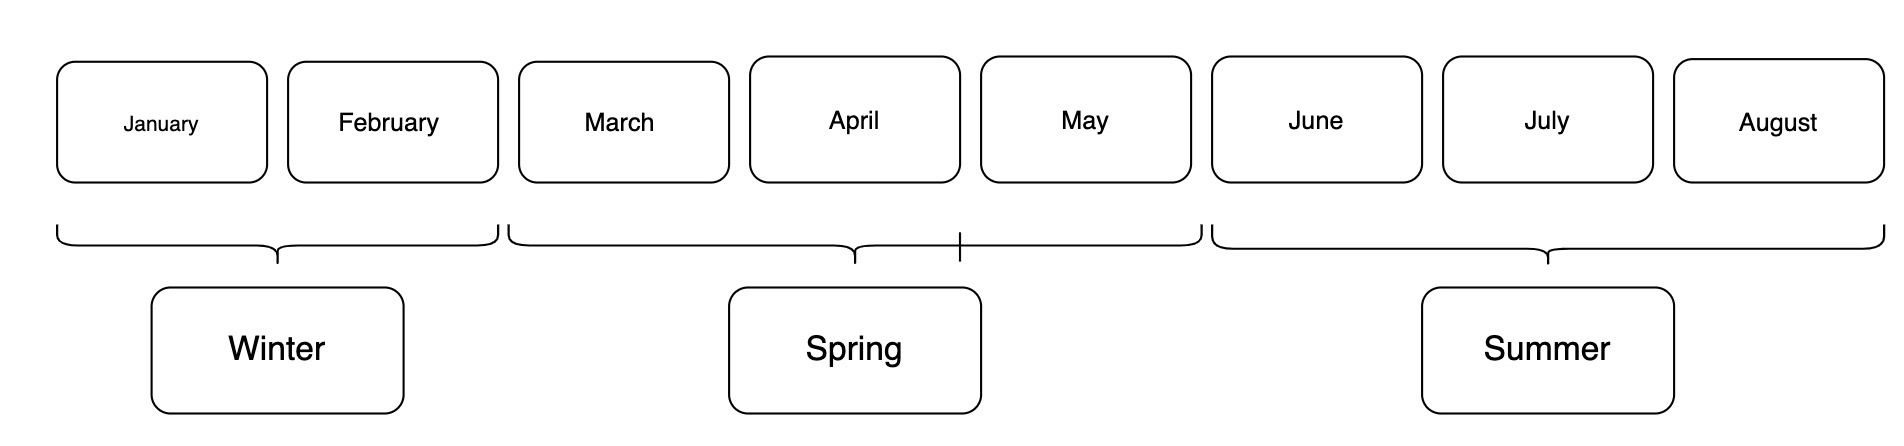

In [ ]:
img = 'Feature images/Season Feature.jpg'
Image(filename=img)

### Region feature

In [ ]:
#Import Dataframe on state code and region location
dfReg = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
dfReg.rename(columns = {'State Code':'StateCode'}, inplace = True)

#Make dictionary for region and state code to map into main datafram
dictReg = pd.Series(dfReg.Division.values,index=dfReg.StateCode).to_dict()

#Map regions to state by the origin and destination 
dfStorm['OriginRegion'] = dfStorm['OriginState'].map(dictReg)
dfStorm['DestRegion'] = dfStorm['DestState'].map(dictReg)

#If a flight travles within the same region, flag the flight as a 1
dfStorm['InterRegion'] = np.where(dfStorm["OriginRegion"] == dfStorm["DestRegion"], 1, 0)


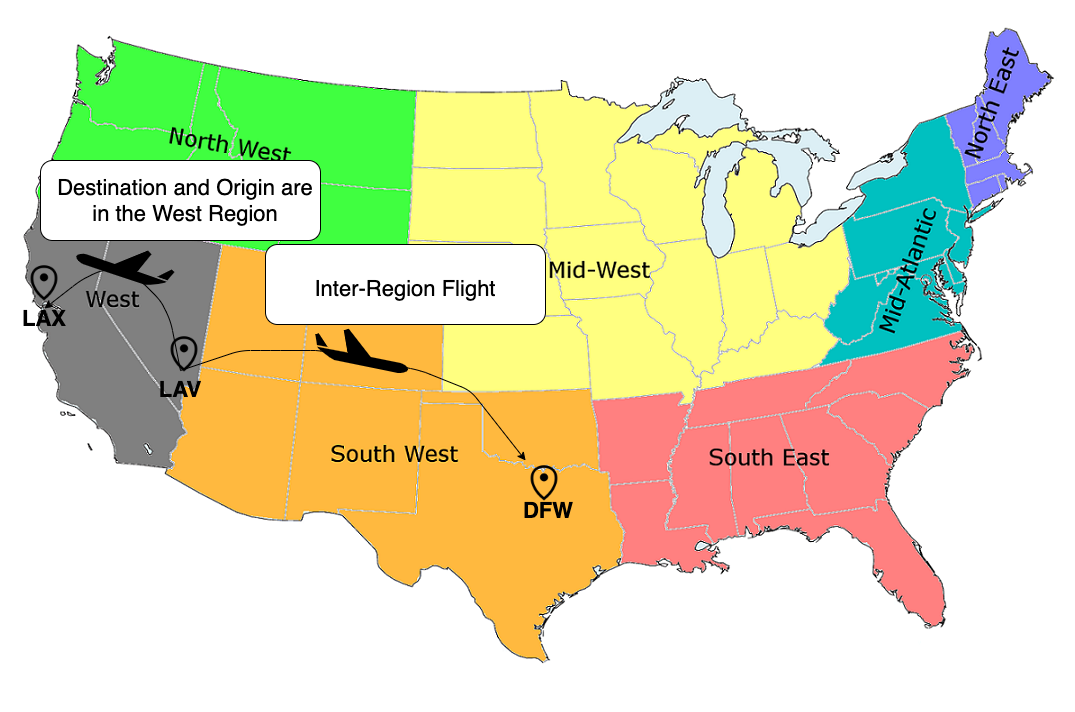

In [ ]:
img = 'Feature images/Region Feature.png'
Image(filename=img)

### Reduced origin and destination feature

In [ ]:
#List of top 10 airports based on maximum cancellations for both origin and destination
list_of_airports_all_codes = ['DFW', 'CLT', 'ORD', 'PHL', 'DCA', 'LGA', 'BOS', 'MIA', 'PHX', 'JFK']
list_of_airports_codeA = ['CLT', 'DFW', 'PHL', 'DCA', 'ORD', 'LGA', 'PHX', 'BOS', 'LAX', 'MIA']
list_of_airports_codeB = list_of_airports_all_codes
list_of_airports_codeC = ['ORD', 'LGA', 'PHL', 'DFW', 'DCA', 'CLT', 'JFK', 'BOS', 'CMH', 'PIT', 'CLE']

In [ ]:
#Any airport which is not in the top 10 list gets marked as 'Other'
list_of_airports = list_of_airports_codeA

def reduce_airport_data(airport):
    apt = 'Other'
    if airport in list_of_airports:
        apt = airport
    return apt

In [ ]:
dfStorm['Origin_airport'] = dfStorm['Origin'].map(lambda x: reduce_airport_data(x))
dfStorm['Destination_airport'] = dfStorm['Dest'].map(lambda x: reduce_airport_data(x))

# Data Encoding

### Convert Flight Operator Feature to CodeShare Boolean
We found this feature to be an important factor within Tableau.

In [ ]:
#Set codeshare feature to 1 if its a codeshare flight or a 0 if its not
dfStorm['Operated_or_Branded_Code_Share_Partners'] = (dfStorm['Operated_or_Branded_Code_Share_Partners'] != dfStorm['Marketing_Airline_Network'])*1
dfStorm = dfStorm.rename(columns={'Operated_or_Branded_Code_Share_Partners':'CodeShare'})
dfCodeShare = dfStorm['CodeShare']

### Apply appropriate transformations to each data class

In [ ]:
#Bin each data column by class
ordinal_cols = ['Hubs']
one_hot_cols = ['CodeShare','IsDestHub','IsOrigHub','Hub2Hub']
#cat_cols = ['OriginRegion','DestRegion','Season','Origin_airport','Destination_airport','DepTimeBlk','ArrTimeBlk']
cat_cols = ['OriginRegion','DestRegion','Origin_airport','Destination_airport','DepTimeBlk','ArrTimeBlk']
num_cols = ['CRSElapsedTime','Distance','AirportTakeOffDensity','AirportLandingDensity','AirlineDensity']
target_col = ['Cancelled']
date = dfStorm['FlightDate']

In [ ]:
#One-Hot encode categorical data and store with other one hot features in a dfOneHot dataframe
dfOneHot = pd.get_dummies(dfStorm[cat_cols])
dfOneHot = pd.concat([dfOneHot,dfStorm[one_hot_cols]],axis = 'columns')
#Scale numerical data and store in dfNum dataframe
dfStorm[num_cols] = scale(dfStorm[num_cols])
dfNum = dfStorm[num_cols]

# Set up the dataframes necessary for model training

### Specify features and target dataframes

In [ ]:
#Specify X as the data features
X = pd.concat([date,dfNum,dfOneHot,dfStorm[ordinal_cols]],axis ='columns')
#Specify y as the data target
y = dfStorm.loc[:,['FlightDate','Cancelled']]

In [ ]:
## additonal scoring dataset
X_score = X[X['FlightDate'].isin(dates_score)]
y_score = y[y['FlightDate'].isin(dates_score)]

X_score = X_score.drop('FlightDate',axis=1)
y_score = y_score.drop('FlightDate', axis=1)

In [ ]:
## split back to original train/test dates 
X = X[X['FlightDate'].isin(dates_train)]
y = y[y['FlightDate'].isin(dates_train)]

X = X.drop('FlightDate',axis=1)
y = y.drop('FlightDate', axis=1)

### Split features and target dataframes into testing and training sets

In [ ]:
#Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Model Creation and Training

### Initialize the model

In [ ]:
#Create classifier model object
model = XGBClassifier(random_state = 1)

### Fit the model to our training data

In [ ]:
#Fit the model to the data
model.fit(X_train, y_train)

### Performance on testing dataset

In [ ]:
#Get and store our model predictions
y_pred_test = model.predict(X_test)

In [ ]:
#Display confusion matrix
print('\n=======================================================\n')
print('CONFUSION MATRIX: \n')
print('  -------')
print('  TP | FP')
print('  FN | TN')
print('  -------')
print(confusion_matrix(y_test, y_pred_test))
print('\n=======================================================\n')
#Display model metrics
print('CLASSIFICATION REPORT:\n')
print(classification_report(y_test, y_pred_test))
print('\n=======================================================\n')
print (f'AUC Score: {roc_auc_score(y_test, y_pred_test)}')
print('\n=======================================================\n')



CONFUSION MATRIX: 

  -------
  TP | FP
  FN | TN
  -------
[[203  40]
 [ 89 122]]


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76       243
         1.0       0.75      0.58      0.65       211

    accuracy                           0.72       454
   macro avg       0.72      0.71      0.71       454
weighted avg       0.72      0.72      0.71       454



AUC Score: 0.7067949993173794




# Model Scoring

In [ ]:
dates_score

['2018-03-05',
 '2018-05-22',
 '2018-10-15',
 '2019-03-28',
 '2019-08-16',
 '2019-10-22',
 '2018-06-20']

In [ ]:
scoring_set = X_score.sample(n=3, random_state=1)
ind = scoring_set.index
scoring_set

,CRSElapsedTime,Distance,AirportTakeOffDensity,AirportLandingDensity,AirlineDensity,OriginRegion_East North Central,OriginRegion_East South Central,OriginRegion_Middle Atlantic,OriginRegion_Mountain,OriginRegion_New England,...,ArrTimeBlk_1900-1959,ArrTimeBlk_2000-2059,ArrTimeBlk_2100-2159,ArrTimeBlk_2200-2259,ArrTimeBlk_2300-2359,CodeShare,IsDestHub,IsOrigHub,Hub2Hub,Hubs
6117689,0.000937,0.097589,0.351574,-0.426381,0.087431,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
2848965,0.127223,-0.007765,-0.408242,-0.426381,-0.902551,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
14567636,3.047599,2.661187,-0.408242,-0.426381,-0.011567,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
col_list = ['FlightDate', 'Operated_or_Branded_Code_Share_Partners', 'CRSDepTime', 'CRSArrTime', 'Origin', 'Dest', 'Cancelled', 'CancellationCode']
df.loc[ind, col_list]

,FlightDate,Operated_or_Branded_Code_Share_Partners,CRSDepTime,CRSArrTime,Origin,Dest,Cancelled,CancellationCode
6117689,2018-10-15,AA_CODESHARE,1850,2054,DFW,ECP,1.0,A
2848965,2018-05-22,AA,1548,1800,BNA,DFW,0.0,NaN
14567636,2019-10-22,AA,625,842,BWI,PHX,1.0,A


In [ ]:
model.predict(X_score.loc[ind])

array([1., 0., 1.])

## Test on the entire scoring dataset

In [ ]:
#Get and store our model predictions
y_pred_score = model.predict(X_score)

In [ ]:
#Display confusion matrix
print('\n=======================================================\n')
print('CONFUSION MATRIX: \n')
print('  -------')
print('  TP | FP')
print('  FN | TN')
print('  -------')
print(confusion_matrix(y_score, y_pred_score))
print('\n=======================================================\n')
#Display model metrics
print('CLASSIFICATION REPORT:\n')
print(classification_report(y_score, y_pred_score))
print('\n=======================================================\n')
print (f'AUC Score: {roc_auc_score(y_score, y_pred_score)}')
print('\n=======================================================\n')



CONFUSION MATRIX: 

  -------
  TP | FP
  FN | TN
  -------
[[387 105]
 [170 411]]


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74       492
         1.0       0.80      0.71      0.75       581

    accuracy                           0.74      1073
   macro avg       0.75      0.75      0.74      1073
weighted avg       0.75      0.74      0.74      1073



AUC Score: 0.746993199277948




## Feature Importance

In [ ]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
feature_list_dict = model.get_booster().get_score(importance_type= f)
pd.DataFrame.from_dict(data=feature_list_dict, orient='index') \
.sort_values(by=0, ascending=False).rename(columns={0:'Feature Importance'}).head(10)

,Feature Importance
AirlineDensity,24.775384
Destination_airport_ORD,12.079502
Destination_airport_CLT,9.309465
AirportLandingDensity,6.413800
Origin_airport_BOS,6.300774
Origin_airport_ORD,6.079392
ArrTimeBlk_0800-0859,5.758788
DepTimeBlk_2000-2059,5.391416
DestRegion_Mountain,5.055191
CodeShare,4.782201


# Takeaways
- Reducing airline density by spreading flights out
- Consider utilizing alternate airports at cities with hubs, starting with Chicago
- Codeshare flights tend to have more cancellations

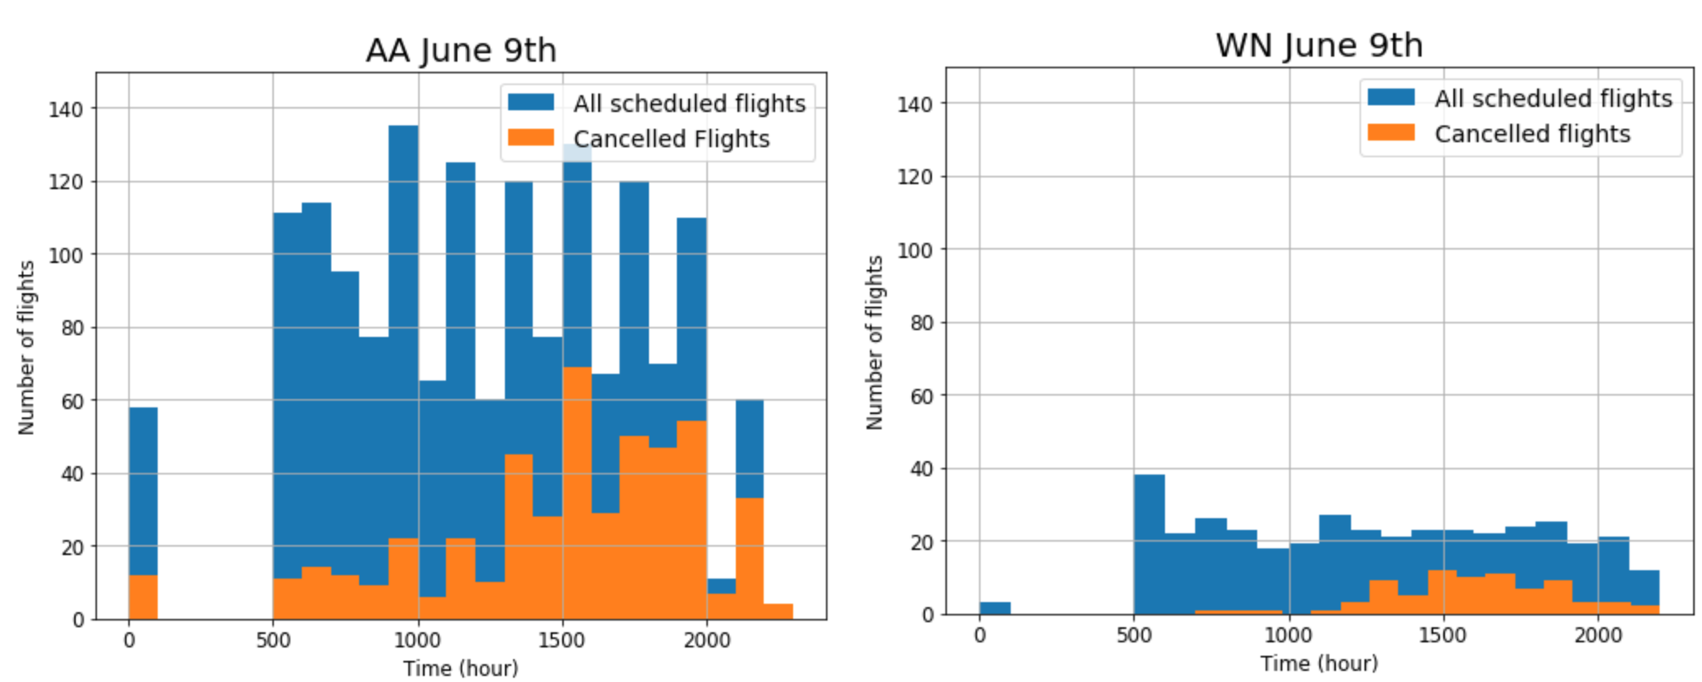

In [ ]:
img = 'AA_WN.png'
Image(filename=img)